In [20]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, make_scorer, recall_score, precision_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, ElasticNet
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTENC

In [2]:
df = pd.read_csv('data/health_survey.csv')
df

,is_diabetes,high_blood_pressure,high_cholesterol,bmi,smoke,exercise,alcohol,gender,mental_health,edu,income,employment,race,flushot,state
0,0,1.0,0.0,2650.0,never_smoked,3.000000e+03,5.397605e-79,1,1.0,college_grad,9.0,0.0,white,0.0,Washington
1,0,0.0,1.0,3269.0,never_smoked,1.000000e+03,5.397605e-79,0,0.0,college_grad,11.0,1.0,white,0.0,Washington
2,1,0.0,0.0,2763.0,everyday_smoker,1.000000e+03,1.870000e+02,0,0.0,highschool_grad,6.0,0.0,white,0.0,Washington
3,1,0.0,0.0,2509.0,never_smoked,2.000000e+03,5.397605e-79,1,0.0,attended_college,6.0,0.0,white,1.0,Washington
4,0,1.0,1.0,2661.0,never_smoked,4.667000e+03,5.397605e-79,1,0.0,attended_college,6.0,1.0,black,0.0,Washington
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411086,0,0.0,NaN,2918.0,everyday_smoker,5.397605e-79,5.397605e-79,0,5.0,highschool_grad,5.0,0.0,white,0.0,Idaho
411087,0,1.0,0.0,2441.0,never_smoked,5.397605e-79,5.397605e-79,1,0.0,attended_college,NaN,1.0,white,0.0,Idaho
411088,0,0.0,0.0,5721.0,former_smoker,5.000000e+03,2.300000e+01,1,0.0,college_grad,7.0,1.0,white,0.0,Idaho
411089,0,1.0,1.0,2037.0,never_smoked,NaN,2.300000e+01,0,15.0,highschool_grad,6.0,0.0,white,0.0,Idaho


In [3]:
df.loc[:,'null_cnt'] = df.isnull().sum(axis=1)
df = df[df['null_cnt']<=1].reset_index(drop=True)
df = df.drop('null_cnt', axis=1)

In [4]:
X = df.drop(['is_diabetes','state'], axis=1)
y = df['is_diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
print(X_train.shape, X_test.shape)

(246847, 13) (105792, 13)


In [24]:
preprocessor = ColumnTransformer(transformers=[
                                ('num', Pipeline([
                                    ('num_imputer', SimpleImputer(strategy='median')), 
                                    ('scaler', MinMaxScaler())]), make_column_selector(dtype_include='number')),
                                ('cat', Pipeline([
                                    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
                                    ('one_hot', OneHotEncoder(handle_unknown='ignore'))]), make_column_selector(dtype_include=object))
                                    ], remainder='drop')
scorer = make_scorer(roc_auc_score)
kf = KFold(n_splits=10, shuffle=True, random_state=2)

def ppline(model):
    result = Pipeline([
                    ('over_sampler', RandomOverSampler(random_state=2)),
                    ('preprocessing', preprocessor), 
                   ('model', model)])
    return(result)

#### Logistic Regression

In [ ]:
# optimize penalty
param_grid = {'C': [.001, .01, .1, 1, 10, 100, 1000],
              'l1_ratio': [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]}

metrics = pd.DataFrame(columns=['roc_train', 'roc_test'])
for c in param_grid['C']:
    for l1_ratio in param_grid['l1_ratio']:
        lr = LogisticRegression(random_state=2, penalty='elasticnet', solver='saga', C=c, l1_ratio=l1_ratio)
        lr_ppl = ppline(lr).fit(X_train, y_train)
        roc_train = roc_auc_score(lr_ppl[1:].predict(X_train), y_train)
        roc_test = roc_auc_score(lr_ppl[1:].predict(X_test), y_test)
        metrics = pd.concat([metrics, pd.DataFrame({'C':[c], 'l1_ratio':[l1_ratio], 'roc_train':[roc_train], 'roc_test':[roc_test]})], ignore_index=True)
print('top 10 higher area under roc curve parameters')
metrics.sort_values(by='roc_test', ascending=False)[:10]

top 10 higher area under roc curve parameters


,roc_train,roc_test,C,l1_ratio
56,0.619417,0.618348,100.0,0.1
61,0.619411,0.618348,100.0,0.6
57,0.619419,0.618348,100.0,0.2
58,0.619419,0.618344,100.0,0.3
55,0.619417,0.618344,100.0,0.0
59,0.619417,0.618344,100.0,0.4
60,0.619412,0.618344,100.0,0.5
76,0.619407,0.618328,1000.0,1.0
68,0.619414,0.618328,1000.0,0.2
71,0.619407,0.618328,1000.0,0.5


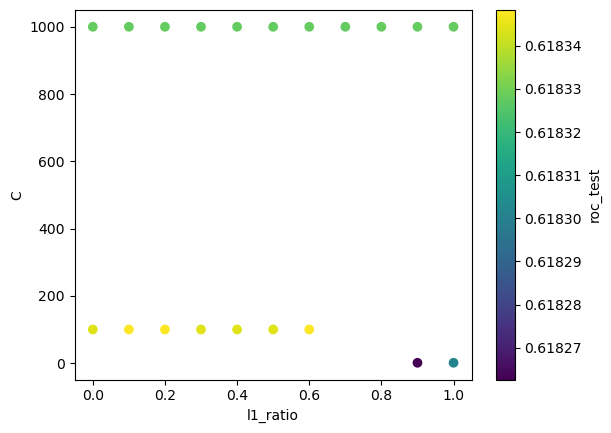

In [76]:
import matplotlib.pyplot as plt
metrics = metrics.sort_values(by='roc_test', ascending=False)[:20]
scatter = plt.scatter(x=metrics['l1_ratio'], y=metrics['C'], c=metrics['roc_test'])

plt.xlabel('l1_ratio')
plt.ylabel('C')
colorbar = plt.colorbar(scatter)
colorbar.set_label('roc_test')

plt.show()

In [73]:
lr_ppl = ppline(LogisticRegression(random_state=2, penalty='elasticnet', solver='saga', C=100, l1_ratio=0.1)).fit(X_train, y_train)
pd.DataFrame(lr_ppl['model'].coef_, columns=lr_ppl[:-1].get_feature_names_out(), index=['coef']).T.sort_values(by='coef')

,coef
num__alcohol,-21.077399
num__exercise,-3.666017
num__employment,-0.643870
num__income,-0.610563
cat__race_white,-0.453559
cat__edu_college_grad,-0.444687
cat__smoke_someday_smoker,-0.370704
cat__smoke_never_smoked,-0.277900
cat__race_others,-0.261758
cat__race_hispanic,-0.245695


There are three main categories of features that are closely related to diabetes
1) Physical Activity and Health (exercise, bmi)
2) Cardiovascular Health (cholesterol, blood pressure)
3) Socioeconomic Factors (employment, income)

The data indicates a negative correlation between alcohol consumption and the prevalence of diabetes, meaning that individuals who consume less alcohol tend to have a higher likelihood of diabetes. However, this does not imply that increasing alcohol consumption reduces the risk of diabetes. Instead, it is possible that individuals with diabetes or those at risk may intentionally limit their alcohol intake as part of their health management strategies.